In [1]:
import torch
from algo_reasoning.src.sampler import CLRSDataset
from pathlib import Path
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/miniconda3/envs/algo_reasoning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def homophily_measure(adj_matrix, classes):
    """
    Compute the homophily measure of the graph
    """
    n = adj_matrix.shape[0]
    homophily = 0
    
    for i in range(n):
        node_homophily = 0
        for j in range(n):
            if classes[i] == classes[j]:
                node_homophily += adj_matrix[i, j]

        node_homophily /= adj_matrix[i].sum()
        homophily += node_homophily

    homophily /= n
    return homophily

In [2]:
def unbiased_homophily(adj_matrix, classes):
    """
    Compute the unbiased homophily measure of the graph
    As described in (https://arxiv.org/pdf/2412.09663)
    """
    classes_unique = torch.unique(classes).int()
    n_classes = classes_unique.size(0)
    n_nodes = adj_matrix.size(0)
    n_edges = 0

    class_adj_matrix = torch.zeros(n_classes, n_classes)

    edges_classes = dict()

    for c1 in classes_unique.tolist():
        for c2 in classes_unique.tolist():
            edges_classes[(c1, c2)] = []

    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if adj_matrix[i, j] > 0:
                n_edges += 1
                class_i = classes[i].item()
                class_j = classes[j].item()

                edges_classes[(class_i, class_j)].append((i, j))

    for c1 in classes_unique.tolist():
        for c2 in classes_unique.tolist():
            class_adj_matrix[c1, c2] = len(edges_classes[(c1, c2)]) + len(edges_classes[(c2, c1)])

            if c1 == c2:
                class_adj_matrix[c1, c2] /= n_edges
            else:
                class_adj_matrix[c1, c2] /= 2*n_edges

    numerator = 0
    denominator = 0
    for c1 in classes_unique.tolist():
        filtered_classes = classes_unique[classes_unique > c1].tolist()
        for c2 in filtered_classes:
            numerator += torch.sqrt(class_adj_matrix[c1, c1]*class_adj_matrix[c2, c2]) - class_adj_matrix[c1, c2]
            denominator += torch.sqrt(class_adj_matrix[c1, c1]*class_adj_matrix[c2, c2]) + class_adj_matrix[c1, c2]
   
    return (numerator/denominator).item()

In [3]:
algorithms = ["articulation_points"]

nb_nodes = [4, 7, 11, 13, 16]
batch_size = 128
ds = CLRSDataset(algorithms, nb_nodes, batch_size, 1000, seed=7, algorithms_args={'p': [0.05, 0.1, 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]})

In [4]:
obj = next(iter(ds))

In [5]:
homophilies = [unbiased_homophily(obj.inputs.A[i], obj.outputs.is_cut[i]) for i in range(128) if torch.sum(obj.outputs.is_cut[i]).item() > 0]

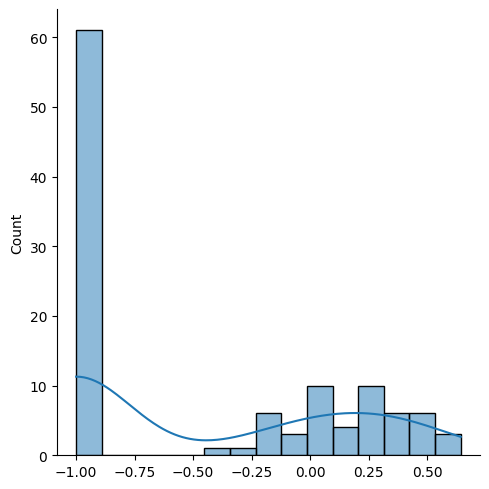

In [6]:
import seaborn as sns

sns.displot(homophilies, kde=True, bins=15)

# Activity Selector

In [19]:
from algo_reasoning.src.models.encoder import preprocess
from algo_reasoning.src.specs import Location, Type, SPECS

def accum_adj_matrix(adj_matrix, _input):
    _input = _input.squeeze(-1)
    adj_matrix += ((_input + _input.permute((0, 2, 1))) > 0.0)

    return adj_matrix

def build_adj_matrix(obj, batch_size, nb_nodes, algorithm, hint_step=None):
    adj_mat = (torch.zeros((nb_nodes, nb_nodes), device=device)[None, :, :]).repeat(batch_size, 1, 1).bool()
    
    for k, value in obj.inputs:
        if k not in SPECS[algorithm]:
            continue
            
        _, loc, type_ = SPECS[algorithm][k]
        _input = preprocess(value, type_, nb_nodes)

        if loc == Location.NODE and type_ == Type.POINTER:
            adj_mat = accum_adj_matrix(adj_mat, _input)
                
        elif loc == Location.EDGE and type_ == Type.MASK:
            adj_mat = accum_adj_matrix(adj_mat, _input)

    if hint_step is not None:
        for k, value in obj.hints:
            if k not in SPECS[algorithm]:
                continue

            
            _, loc, type_ = SPECS[algorithm][k]
            
            value = value[:, hint_step]
            _input = preprocess(value, type_, nb_nodes)

            if loc == Location.NODE and type_ == Type.POINTER:
                adj_mat = accum_adj_matrix(adj_mat, _input)
                    
            elif loc == Location.EDGE and type_ == Type.MASK:
                adj_mat = accum_adj_matrix(adj_mat, _input)

    return adj_mat.float()

In [20]:
algorithms = ["activity_selector"]

nb_nodes = 16
batch_size = 128
activity_selector = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7)

In [21]:
obj = next(iter(activity_selector))

In [22]:
adj_mat = build_adj_matrix(obj, batch_size, nb_nodes, algorithms[0], hint_step=-1)
adj_mat

tensor([[[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        ...,

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0., 

In [23]:
homophilies = [unbiased_homophily(adj_mat[i], obj.outputs.selected[i]) for i in range(128)]

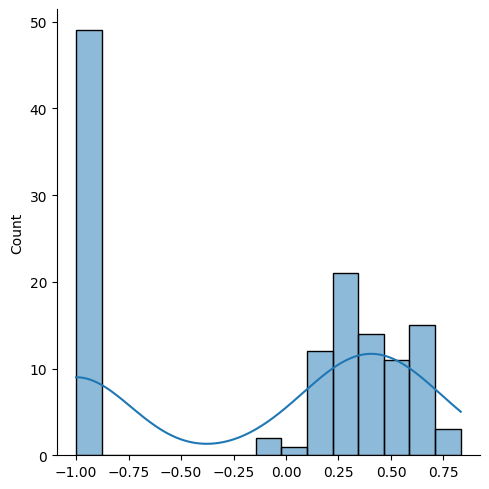

In [24]:
sns.displot(homophilies, kde=True, bins=15)

# Task Scheduling

In [25]:
algorithms = ["task_scheduling"]

nb_nodes = 16
batch_size = 128
task_scheduling = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7)

In [26]:
obj = next(iter(activity_selector))

In [27]:
adj_mat = build_adj_matrix(obj, batch_size, nb_nodes, algorithms[0], hint_step=-1)
adj_mat

tensor([[[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        ...,

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0., 

In [28]:
homophilies = [unbiased_homophily(adj_mat[i], obj.outputs.selected[i]) for i in range(128)]

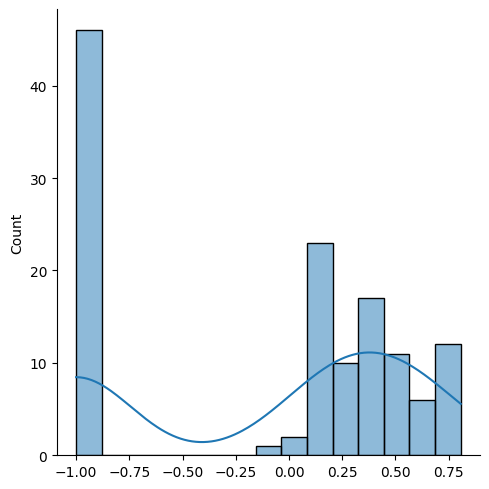

In [29]:
sns.displot(homophilies, kde=True, bins=15)

# Graham Scan

In [30]:
algorithms = ["graham_scan"]

nb_nodes = 16
batch_size = 128
graham_scan = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7)

In [37]:
obj = next(iter(graham_scan))

In [47]:
adj_mat = build_adj_matrix(obj, batch_size, nb_nodes, algorithms[0], hint_step=-1)
adj_mat

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0., 

In [48]:
homophilies = [unbiased_homophily(adj_mat[i], obj.outputs.in_hull[i]) for i in range(128)]

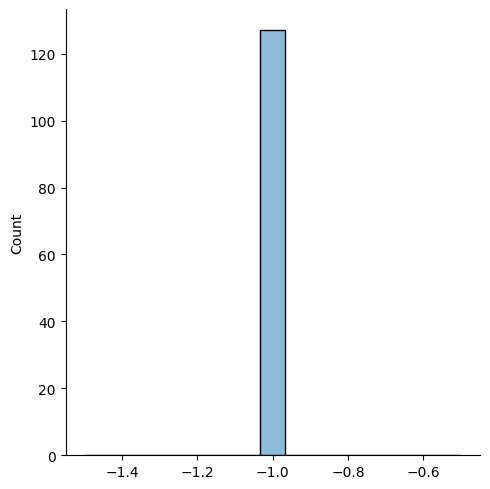

In [49]:
sns.displot(homophilies, kde=True, bins=15)

# Jarvis March

In [50]:
algorithms = ["jarvis_march"]

nb_nodes = 16
batch_size = 128
jarvis_march = CLRSDataset(algorithms, [16], batch_size, 1000, seed=7)

In [52]:
obj = next(iter(jarvis_march))

In [53]:
adj_mat = build_adj_matrix(obj, batch_size, nb_nodes, algorithms[0], hint_step=-1)
adj_mat

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0., 

In [54]:
homophilies = [unbiased_homophily(adj_mat[i], obj.outputs.in_hull[i]) for i in range(128)]

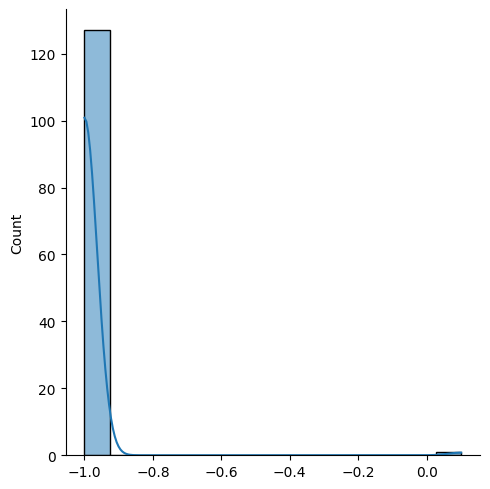

In [55]:
sns.displot(homophilies, kde=True, bins=15)